In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import gc
import copy
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.base import BaseEstimator, ClassifierMixin
from os import listdir, mkdir
from os.path import isfile, join
import math
from datetime import datetime
import time
from skimage.transform import radon

In [2]:
def rgb2gray(rgb):
    '''
    Turns image with 4 color channels into double-dimensional
    '''
    if (len(rgb.shape) == 3):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    else:
        gray = rgb
    return gray

def S(image, axis='x', offset=1, boundary='symm'):
    '''
    Offset operator of image along given axis
    '''
    if offset == 0:
        return image
    width = image.shape[1] 
    height = image.shape[0] 
    out_image = np.ndarray([height, width], dtype=float)
    if axis == 'x':
        if offset > 0:
            for i in range(offset):
                out_image[:, offset - i] = image[:, i]
            for i in range(offset, width):
                out_image[:, i] = image[:, i- offset]
        else:
            offset = -offset
            for i in range(offset):
                out_image[:, width - 1 - offset + i] = image[:, width - 1 - i]
            for i in range(width - 1 - offset):
                out_image[:, i] = image[:, i + offset]
    if axis == 'y':
        if offset > 0:
            for i in range(offset):
                out_image[offset - i] = image[i]
            for i in range(offset, height):
                out_image[i] = image[i - offset]
        else:
            offset = -offset
            for i in range(offset):
                out_image[height - 1 - offset + i] = image[height - 1 - i]
            for i in range(height - 1 - offset):
                out_image[i] = image[i + offset]
                
    return out_image

class FunctionalMinimisation:
    '''
    Z_alpha = arg min(||Az - u||_1 + TV[z])
    
    grad(Z_alpha) = 2A^T(Az-u) + mult * D(TV[z])
    '''
    def __init__(self, image, kernel, beta_list):
        self._init_image = copy.deepcopy(image)
        self._cur_image = copy.deepcopy(image)
        self.kernel = copy.deepcopy(kernel)
        
        self._left_grad = 0
        self._reg_grad = 0
        
        self._betas = beta_list
        self._mu = 0.85
        self._v = 0
        return
        
    def _sign_map(self, image, x_offset, y_offset):
        '''
        For derivative of Total Variation
        '''
        return np.sign(S(S(image, axis='x', offset=x_offset), axis='y', offset=y_offset) - image)

    def _offset_image(self, image, x_offset, y_offset):
        '''
        Returns image, shifted in x_offset pixels along X and in y_offset pixels along Y
        '''
        return S(S(image, axis='x', offset = x_offset), axis='y', offset = y_offset)
    
    def _count_gradient(self):
        
        Q = [[1, 0], [0, 1], [1, 1], [1, -1]]
    
        reg_grad = 0
        
        for cur_Q in Q:
            a = self._sign_map(self._cur_image + self._mu * self._v, cur_Q[0], cur_Q[1])
#             a = self._sign_map(self._cur_image, cur_Q[0], cur_Q[1])
            reg_grad += (1/math.sqrt(cur_Q[0]**2 + cur_Q[1]**2)) *\
                (self._offset_image(a, - cur_Q[0], - cur_Q[1]) - a)

        self._reg_grad = reg_grad
        self._left_grad = 2 * ss.convolve2d(ss.convolve2d(
                                                    self._cur_image + self._mu * self._v,
                                                    self.kernel,
                                                    mode='same',
                                                    boundary='symm')\
                                                - self._init_image,\
                                                self.kernel,
                                                mode='same',
                                                boundary='symm')
        return
        
    def _count_v(self, beta = 1):
        '''
        Nesterov accelerated gradient(II variant in presentation)
        g_k = grad(f(z_k + mu * v_k))
        v_(k+1) = mu * v_k - beta_k * g_k
        z_(k+1) = z_k + v_(k+1)
        '''
        mult = 0.5
        reg_mult = 0.001
        self._v = self._mu * self._v - beta * mult * (self._left_grad + reg_mult * self._reg_grad)
#         self._v = self._mu * self._v - beta * mult * (self._left_grad + reg_mult * self._reg_grad)
        
    def _update_image(self):
#         self._cur_image += self._v
        self._cur_image += self._v
        
    def MainProcess(self):
        for i in self._betas:
            self._count_gradient()
            self._count_v(i)
            self._update_image()
    
def FixImage(image):
    '''
    Returns image with values in [0, 1] segment
    for normal output with possible negative elements
    '''
    min_value = image.min()
    max_value = image.max()
    if min_value < 0:
        image -= min_value
    return image / (max_value - min_value)
        
def images_out(class_elem):
    '''
    Relatively normal output 
    of _cur_image and _init_image 
    in element of FunctionalMinimisation class
    '''
    plt.figure(figsize=(35,35))
    plt.subplot(1,2,1)
    plt.imshow(FixImage(class_elem._cur_image), cmap='gray')

    plt.subplot(1,2,2)
    plt.imshow(FixImage(class_elem._init_image), cmap='gray')

def save_img(class_elem, p='my_stuff.png', p_b='blurred.png'):
    plt.imsave(p, class_elem._cur_image, cmap='gray')
    plt.imsave(p_b, class_elem._init_image, cmap='gray')

In [22]:
DEBUG = True

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b
    return gray

def blend_images(orig, four, alpha = 0.8, colH = 10, w=1):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = colH, 255
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, alpha)
    return new_img

def calculate_log(picture,threshold=0.5):
    log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
    fourier_abs = np.abs(log)
    return fourier_abs

def get_ceps(picture):
    hm_len = picture.shape[0]
    bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
    bw2d = bw2d * bw2d.T
    log = np.log(np.abs(np.fft.fft2(picture * bw2d)))
    fourier_abs = np.abs(np.fft.ifft2(log))
    threshold = 0.5
    fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
    fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0

    return fourier_abs

def wiener_filter(img, kernel, K=10):
    if kernel.shape[0] == 0:
        return img
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def restore_function(img, kernel):
    betas = [0.1/math.sqrt(i) for i in range(1, 15)]
    if (kernel.shape[0] == 0):
        return img
    q = FunctionalMinimisation(img, kernel, betas)
    q.MainProcess()
    return q._cur_image

def get_blur_len(img, angle):
    r = radon(img, theta=[angle], circle=True)
    r *= 1./max(r)

    blur_len = 0
    for i in range(len(r)):
        if (r[i] > 0.7):
            blur_len = len(r) // 2 - 1 - i 
            if (blur_len > 2 * img.shape[0] // 5):
                blur_len = 0
            break
    return int(abs(blur_len))

def find_best_line(template_picture, dif=30, w=1):
    h = template_picture.shape[0]
    q = h // 2 - 1
    theta = np.linspace(0., 180., dif, endpoint=False)
    sinogram = radon(template_picture, theta=theta, circle=True)
    max_values = sinogram.max(axis=0)
    if (DEBUG):
        angle = theta[np.argmax(max_values)]
        k = math.tan(angle)
        b = (1 - k) * q
        l = []
        for old_x in range(h):
            old_y = round(k * old_x+b)
            old_y = int((old_y if old_y >= 0 else 0) if old_y <= h-1 else h-1)
            if (old_y <= 1 or old_y >= h-2 or old_x <= 1 or old_x >= h-2):
                continue
            for i in range(-w, w+1):
                for j in range(-w, w+1):
                    x = old_x
                    y = old_y
                    y += i
                    y = (y if y >= 0 else 0) if y <= h-1 else h-1
                    x += j
                    x = (x if x >= 0 else 0) if x <= h-1 else h-1
                    if (y, x) not in l:
                        l.append((y, x))
        p = np.zeros((template_picture.shape[0], template_picture.shape[0]))
        mv = max(max_values)
        for t in l:
            p[t] = mv
        return (mv, p, theta[np.argmax(max_values)])
    else:
        return (max(max_values), 0, theta[np.argmax(max_values)])

def make_ker(ker_len, ker_angle):
    h = ker_len * 2
    ker = np.zeros((h, h))
    k = math.tan(ker_angle)
    b = (1 - k) * ker_len
    for x in range(h):
        y = round(k * x + b)
        y = int((y if y >= 0 else 0) if y <= h-1 else h-1)
        if (y == 0 or y == h - 1):
            continue
        ker[y, x] = 1
    return ker/ker.sum()

def make_common_ker(kers):
    max_shape = max([a.shape[0] for a in kers])
    new_ker = np.zeros((max_shape, max_shape))
    for k in kers:
        cur_shape = k.shape[0]
        if (cur_shape == 0):
            continue
        cur_offset = (max_shape - cur_shape) // 2
        for y in range(cur_shape):
            for x in range(cur_shape):
                new_ker[y + cur_offset, x + cur_offset] += k[y, x]
    return new_ker/new_ker.sum()

In [36]:
class Cepstrum:
    def __init__(self, picture, batch_size=64, step=0.25):
        gc.enable()
        self.batch_size = batch_size
        self.step = step
        self.x_batches = int(picture.shape[1] // (batch_size * step) - 1)
        self.y_batches = int(picture.shape[0] // (batch_size * step) - 1)
        self.picture = copy.deepcopy(picture)
#         self.squared_image = [0] * self.x_batches * self.y_batches
        plt.imsave('orig_img.png', self.picture, cmap='gray')

    def get_square(self):
        pixel_step = int(self.batch_size * self.step)
        for y in range(self.y_batches):
            for x in range(self.x_batches):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
#                 self.squared_image[y * self.x_batches + x] = square
                yield self.swap_quarters(Cepstrum.calculate_cepstrum(square))

    def ft_array(self):
        a = np.array(list(self.get_square()))
        if (DEBUG):
            b = np.copy(a)
            self.new_image = np.copy(a)
        self.weight = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        self.angle = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        self.blur_len = np.ndarray((self.y_batches * self.x_batches), dtype='int')
        self.kernels = [0] * self.y_batches * self.x_batches
        # MAIN CALCULATIONS PART #
        for idx, q in enumerate(a):
            if (DEBUG):
                self.weight[idx], b[idx], self.angle[idx] = find_best_line(q)
            else:
                self.weight[idx], _, self.angle[idx] = find_best_line(q)
            self.blur_len[idx] = get_blur_len(b[idx], self.angle[idx])
            self.kernels[idx] = make_ker(self.blur_len[idx], self.angle[idx])
#             self.squared_image[idx] = restore_function(self.squared_image[idx], self.kernels[idx])
        self.output = a.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        if (DEBUG):
            self.lines_img = b.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        self.weight = self.weight.reshape((self.y_batches, self.x_batches))
        self.weight /= self.weight.max()
        self.angle = self.angle.reshape((self.y_batches, self.x_batches))
        self.blur_len = self.blur_len.reshape((self.y_batches, self.x_batches))
        if (np.max(self.blur_len) == 0) :
            print("Unable to calculate blur lengths")
            return
        self.kernels = np.reshape(self.kernels, (self.y_batches, self.x_batches))
#         self.squared_image = np.reshape(self.squared_image, (self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        self.restore()
        
    def make_big_image(self):
        self.ft_array()
        try:
            temp = [ 0 ] * self.y_batches
            temp1 =[ 0 ] * self.y_batches
            temp2 =[ 0 ] * self.y_squares
            for y in range(self.y_batches):
                temp[y] = np.hstack(self.output[y, :, :, :])
                if (DEBUG):
                    temp1[y] = np.hstack(self.lines_img[y, :, :, :])
            for y in range(self.y_squares):
                temp2[y] = np.hstack(self.restored_image[y, :, :, :])
            self.big_image = np.vstack(temp)
            self.restored_image_full = np.vstack(temp2)
            if (DEBUG):
                self.lines_img = np.vstack(temp1)
            return self.big_image
        except AttributeError:
            print("!!! Use ft_array() function first !!!")
            
    def hamming(picture):
        hm_len = picture.shape[0]
        bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
        bw2d = bw2d * bw2d.T
        return picture * bw2d
    
    def calculate_cepstrum(picture,threshold=0.5):
        log = np.log(1 + np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
        fourier_abs = np.abs(np.fft.ifft2(log))
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
        
#         fourier_abs *= (1.0/fourier_abs.max())
#         fourier_abs[fourier_abs < 0.1] = 0
        return fourier_abs
    
    def threshold_big_image(self, threshold=0.9):
        fourier_abs = self.big_image
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold] = 0
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs > threshold] = 0
        
        fourier_abs *= (1.0/fourier_abs.max())
        fourier_abs[fourier_abs < 0.1] = 0
        self.big_image = fourier_abs
        return self.big_image
    
    def swap_quarters(self, picture):
        out_pict = copy.deepcopy(picture)
        batch_size = picture.shape[0]
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, : batch_size//2])
        out_pict[: batch_size//2, : batch_size//2] = out_pict[batch_size//2 :, batch_size//2 :]
        out_pict[batch_size//2 :, batch_size//2 :] = temp_pict
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, batch_size//2 :])
        out_pict[: batch_size//2, batch_size//2 :] = out_pict[batch_size//2 :, : batch_size//2]
        out_pict[batch_size//2 :, : batch_size//2] = temp_pict[:]
        return out_pict
    
    def restore(self):
        self.cut_image = []
        pixel_step = self.batch_size
        self.y_squares = int(self.picture.shape[0] // self.batch_size)
        self.x_squares = int(self.picture.shape[1] // self.batch_size)
        for y in range(self.y_squares):
            for x in range(self.x_squares):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
                self.cut_image.append(square)
        self.cut_image = np.reshape(self.cut_image, (self.y_squares, self.x_squares, pixel_step, pixel_step))
        self.restored_image = np.copy(self.cut_image)

        ker_divider = int(1. / self.step)
        self.new_kernels = [[0] * self.x_squares] * self.y_squares
        
        def tf(y, x):
            new_y = int((y if y >= 0 else 0) if y <= self.y_batches - 1 else self.y_batches - 1)
            new_x = int((x if x >= 0 else 0) if x <= self.x_batches - 1 else self.x_batches - 1)
            return (new_y, new_x)
        
        for y_orig in range(self.y_squares):
            for x_orig in range(self.x_squares):
                k_l = []
                for y in range(-ker_divider + 1, ker_divider):
                    for x in range(-ker_divider + 1, ker_divider):
                        k_l.append(self.kernels[tf(y_orig * ker_divider + y, x_orig * ker_divider + x)])

                self.new_kernels[y_orig][x_orig] = make_common_ker(k_l)
                
                self.restored_image[y_orig, x_orig] =\
                    restore_function(self.cut_image[y_orig, x_orig], self.new_kernels[y_orig][x_orig])
        return self.restored_image
                    
work_dir = "../pict/"
s = str(datetime.now())
save_dir = '../res_' + s[8:10] + '_' + s[5:7] + '/'
print(save_dir)
try:
    # Create target Directory
    mkdir(save_dir)
except FileExistsError:
    print("Directory " , save_dir ,  " already exists")

../res_24_03/
Directory  ../res_24_03/  already exists


In [37]:
work_dir = "../pict/"

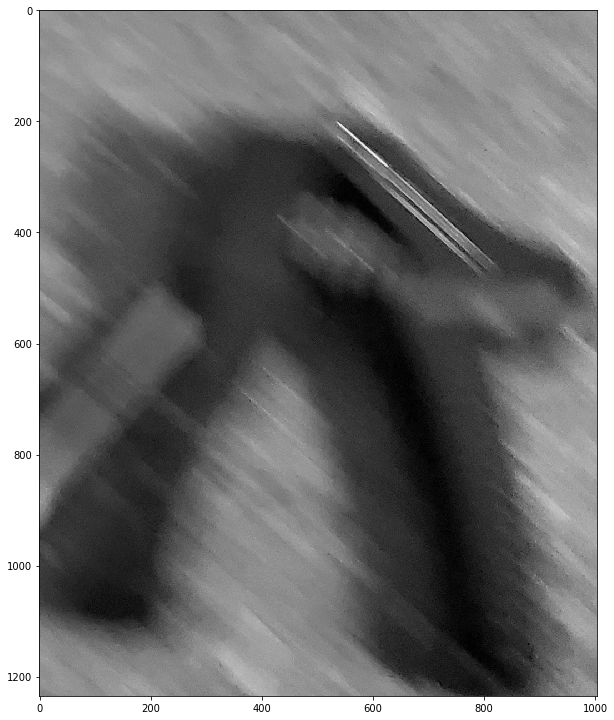

In [38]:
# filename = "mb0.jpg"
filename = "low_pig_rotated.jpg"
filename = "q.jpg"

img = rgb2gray(plt.imread(work_dir + filename))

plt.figure(figsize=(10,230))
plt.imshow(img, cmap='gray')

In [39]:
%%time
c = Cepstrum(img, batch_size=256, step=0.5)

q = c.make_big_image()
plt.imsave('big_img.png', q, cmap='gray')

if (DEBUG):
    plt.imsave('lines_img.png', c.lines_img, cmap='gray')

    d = blend_images('orig_img.png', 'big_img.png')
    d.save('temp_vis.png')
    
    d = blend_images('temp_vis.png', 'lines_img.png', alpha=0.2, colH = 120)
    d.save(save_dir + filename[:-4] +'_vis.png')

    d = blend_images('orig_img.png', 'lines_img.png', alpha=0.6, colH = 120)
    d.save(save_dir + filename[:-4] +'_lines.png')
    
    plt.imsave(save_dir + filename[:-4] + '_restored_img.png', c.restored_image_full, cmap='gray')
    gc.collect()

D:\ProgramFiles\Anaconda\lib\site-packages\skimage\transform\radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Wall time: 7min 56s


In [98]:
# a = c.output[9, 8]
a = c.output[1, 3]
k = make_ker(c.blur_len[1,3], c.angle[1,3])
print(s)
# a = c.output[9, 0] #bad one

[[135.292 133.292 133.292 ... 140.193 136.72  135.72 ]
 [138.292 134.292 132.292 ... 137.193 134.72  134.72 ]
 [138.292 135.292 134.292 ... 140.193 139.193 139.72 ]
 ...
 [ 55.83   49.83   52.83  ...  43.412  45.412  43.412]
 [ 56.83   49.83   55.83  ...  35.412  38.412  41.412]
 [ 43.83   49.83   56.83  ...  24.184  34.184  41.412]]
(7, 5, 256, 256)


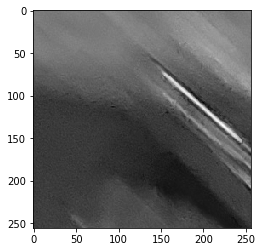

In [101]:
betas = [0.1/math.sqrt(i) for i in range(1, 20)]
d = FunctionalMinimisation(s, k, betas)
d.MainProcess()
plt.imshow(d._cur_image, cmap='gray')

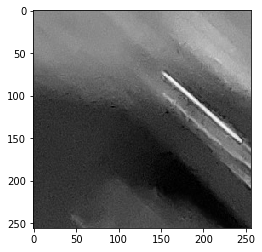

In [100]:
plt.imshow(s, cmap='gray')
plt.imsave('local_cep1.png', a, cmap='gray')

In [16]:
%%time
filenames = ['mb0.jpg', 'pig_lil.jpg']
# filenames = ['low_pig.jpg', 'mb0_low.jpg']
# filenames = ['pig_lil.jpg']

for filename in filenames:
    img = rgb2gray(plt.imread(work_dir + filename))
    c = Cepstrum(img, batch_size=256, step=0.5)
    c.ft_array()

    q = c.make_big_image()
    plt.imsave('big_img.png', q, cmap='gray')
    if (DEBUG):
        plt.imsave('lines_img.png', c.lines_img, cmap='gray')

        d = blend_images('orig_img.png', 'big_img.png')
        d.save('temp_vis.png')

        d = blend_images('temp_vis.png', 'lines_img.png', alpha=0.2, colH = 120)
        d.save(save_dir + filename[:-4] +'_vis.png')

        d = blend_images('orig_img.png', 'lines_img.png', alpha=0.6, colH = 120)
        d.save(save_dir + filename[:-4] +'_lines.png')
        
        plt.imsave(save_dir + filename[:-4] + '_restored_img.png', c.restored_image_full, cmap='gray')
        gc.collect()

KeyboardInterrupt: 

In [35]:
np.max(c.blur_len)

87